In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import skewnorm, skew, norm, shapiro

In [10]:
def tskew(alpha):
    """給定alpha, 計算理論的偏度值"""
    d = alpha / np.sqrt(1+alpha**2)
    return (4-np.pi)/2 * (d*np.sqrt(2/np.pi)) ** 3 / (1-2*d**2/np.pi) ** (3/2)

In [2]:
def gen_skewnormal(mean, var, alpha, size, random_state=None):
    # generate standard skew normal distribution
    X = skewnorm.rvs(alpha, loc=0, scale=1, size=size, random_state=random_state)
    
    # theory expectation value (mean) and variance of standard skew normal distribution
    tmean = np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    tvar = 1 - 2/np.pi * alpha**2 / (1+alpha**2)

    # (1)adjust var (2)adjust mean. Order can not reverse
    X = np.sqrt(var/tvar) * X
    tmean = np.sqrt(var/tvar) * np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    X = X + mean - tmean
    
    return X

In [3]:
X = gen_skewnormal(5, 2, 4, 100000, 42)
X.var()

2.004927890730308

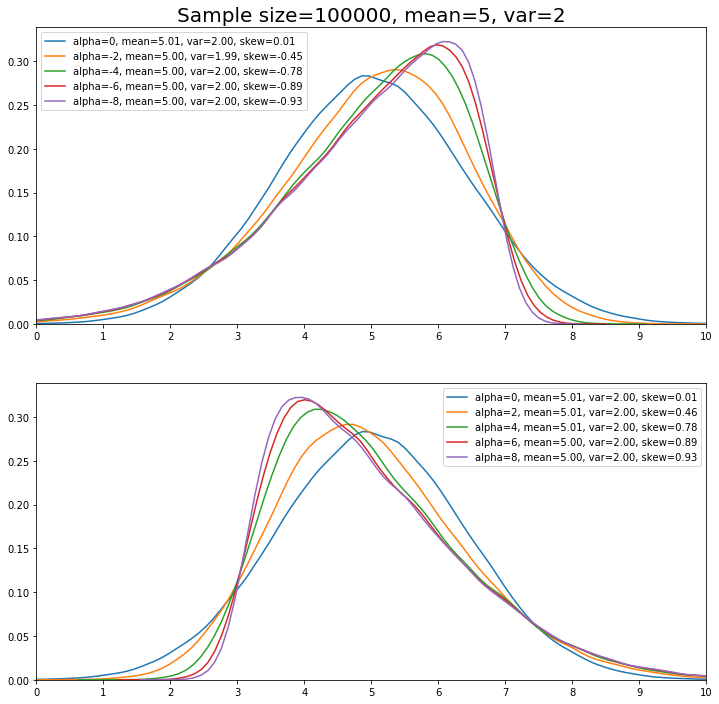

In [4]:
size = 100000
mean = 5
var = 2

fig, axs = plt.subplots(figsize=(12, 12), nrows=2)
for alpha in np.arange(0, 10, 2):
    alpha *= -1
    X = gen_skewnormal(mean, var, alpha, size, 42)
    sns.kdeplot(X, label=f'alpha={alpha}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}', ax=axs[0])

for alpha in np.arange(0, 10, 2):
    X = gen_skewnormal(mean, var, alpha, size, 42)
    sns.kdeplot(X, label=f'alpha={alpha}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}', ax=axs[1])
    
title = f'Sample size={size}, mean={mean}, var={var}'
axs[0].set_title(title, fontsize=20)
axs[0].set_xlim([mean-5, mean+5])
axs[0].set_xticks([i for i in range(0, 11)])
axs[1].set_xlim([mean-5, mean+5])
axs[1].set_xticks([i for i in range(0, 11)]);

### Find the experiment alpha values

In [181]:
### find a random seed that the skewness of generated X is close to theory value

alphas = np.arange(0.15, 1.65, 0.3)

size = 4500
for alpha in alphas:
    for _ in range(100):
        rseed = np.random.randint(0, 200)
        X = gen_skewnormal(0, 2, alpha, size, rseed)
        if alpha == 0:
            if np.abs(skew(X)) <= 0.01:
                print(f'alpha = {alpha:.2f}, rseed = {rseed:3d}, tskew = {tskew(alpha):.3f}, skew = {skew(X):6.3f}')
                break
        else:
            if np.abs(skew(X) - tskew(alpha)) <= 0.1 * tskew(alpha):
                print(f'alpha = {alpha:.2f}, rseed = {rseed:3d}, tskew = {tskew(alpha):.3f}, skew = {skew(X):6.3f}')
                break
    else:
        print(f'alpha = {alpha:.2f}, rseed = {rseed:3d}, tskew = {tskew(alpha):.3f}, skew = {skew(X):6.3f}'
              + '  FAIL to find the best rseed.')

alpha = 0.15, rseed =  58, tskew = 0.001, skew =  0.033  FAIL to find the best rseed.
alpha = 0.45, rseed =  97, tskew = 0.018, skew =  0.018
alpha = 0.75, rseed =   0, tskew = 0.070, skew =  0.075
alpha = 1.05, rseed = 124, tskew = 0.152, skew =  0.161
alpha = 1.35, rseed = 132, tskew = 0.250, skew =  0.226


,mean,var,tskew,skew,W,p-value
0.15,0.000881,1.934791,0.001,0.033,1.000,0.66832
0.45,-0.007957,1.930086,0.018,0.018,1.000,0.73021
0.75,-0.028184,1.961639,0.070,0.075,0.999,0.05804
1.05,0.013837,1.931826,0.152,0.161,0.998,0.00006
1.35,-0.004664,1.996977,0.250,0.226,0.997,0.00000


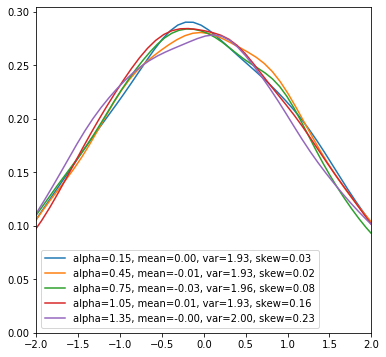

In [182]:
fig, ax = plt.subplots(figsize=(6, 6))

result = {}
rseeds = [58, 97, 0, 124, 132]
for rseed, alpha in zip(rseeds, alphas):
    X = gen_skewnormal(0, 2, alpha, size, rseed)
    W, p = shapiro(X)
    result[alpha] = [X.mean(), X.var(), tskew(alpha), skew(X), W, p]
    label = f'alpha={alpha:.2f}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}'
    sns.kdeplot(X, label=label, ax=ax)
    
ax.set_xlim([-2, 2])

df = pd.DataFrame(result, index=['mean', 'var', 'tskew', 'skew', 'W', 'p-value']).T
df.index.name = 'alpha'

df_s = df.copy()
df_s.index = [f'{idx:.2f}' for idx in df_s.index]
df_s['tskew'] = df_s['tskew'].map(lambda y: f'{y:.3f}')
df_s['skew'] = df_s['skew'].map(lambda y: f'{y:.3f}')
df_s['W'] = df_s['W'].map(lambda y: f'{y:.3f}')
df_s['p-value'] = df_s['p-value'].map(lambda y: f'{y:.5f}')
df_s

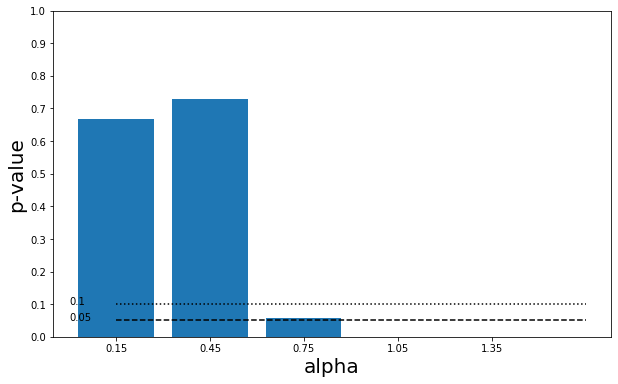

In [183]:
plt.figure(figsize=(10, 6))
x = df_s.index.values
p = df['p-value'].values
plt.bar(x, p)

plt.hlines(0.1, 0, len(alphas), ls='dotted')
plt.hlines(0.05, 0, len(alphas), ls='dashed')
plt.text(-0.5, 0.1, '0.1')
plt.text(-0.5, 0.05, '0.05')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('alpha', fontsize=20)
plt.ylabel('p-value', fontsize=20);

### 測試 skewnorm 的 sampling error。看樣本數要多少，用正負alpha各自計算出來的偏度才會同值異號

In [7]:
def tskew(alpha):
    """給定alpha, 計算理論的偏度值"""
    d = alpha / np.sqrt(1+alpha**2)
    return (4-np.pi)/2 * (d*np.sqrt(2/np.pi)) ** 3 / (1-2*d**2/np.pi) ** (3/2)

size = 50
alpha = 0.4:   skew=-0.20702549322803726
alpha = -0.4:  skew=-0.06965321205319897
size = 100
alpha = 0.4:   skew=-0.03182840208136271
alpha = -0.4:  skew=0.3480552545972041
size = 1000
alpha = 0.4:   skew=-0.027144658706966845
alpha = -0.4:  skew=-0.09442823203028418
size = 10000
alpha = 0.4:   skew=0.039109606753321695
alpha = -0.4:  skew=-0.04225719907851484
size = 100000
alpha = 0.4:   skew=0.018057899759034927
alpha = -0.4:  skew=-0.011889580841945713
size = 1000000
alpha = 0.4:   skew=0.012525089709046902
alpha = -0.4:  skew=-0.013583161178366046
size = 2000000
alpha = 0.4:   skew=0.013404020658364482
alpha = -0.4:  skew=-0.01355641954957267
size = 5000000
alpha = 0.4:   skew=0.01261323742928594
alpha = -0.4:  skew=-0.011760350855185077


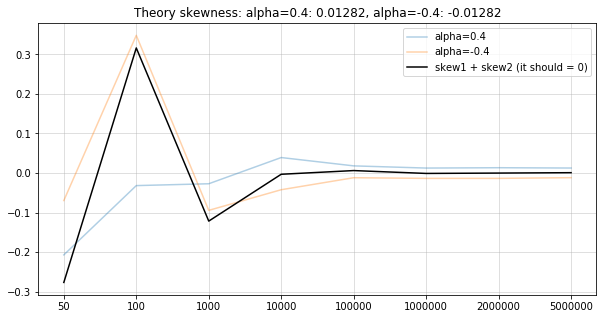

In [8]:
### alpha = 0.4 or -0.4

alpha = 0.4
sk1 = []
sk2 = []
test_size = [50, 100, 1000, 10000, 100000, 1000000, 2000000, 5000000]
for size in test_size:
    x1 = skewnorm.rvs(alpha, loc=0, scale=1, size=size)
    sk1.append(skew(x1))
    x2 = skewnorm.rvs(-alpha, loc=0, scale=1, size=size)
    sk2.append(skew(x2))
    print(f'size = {size}')
    print(f'alpha = {alpha}:   skew={skew(x1)}')
    print(f'alpha = {-alpha}:  skew={skew(x2)}')

# 計算skewnorm的樣本偏度，似乎要到萬等級的樣本數，偏度值才會比較穩定
plt.figure(figsize=(10, 5))
plt.plot(sk1, alpha=0.35, label=f'alpha={alpha}')
plt.plot(sk2, alpha=0.35, label=f'alpha={-alpha}')

sk12 = [i+j for i, j in zip(sk1, sk2)]  # it should be zero, if no sampling error
plt.plot(sk12, color='k', label='skew1 + skew2 (it should = 0)')
plt.grid(True, alpha=0.5)
plt.xticks(ticks=range(len(test_size)), labels=test_size)
plt.legend()
plt.title(f'Theory skewness: alpha={alpha}: {tskew(alpha):.5f}, alpha={-alpha}: {tskew(-alpha):.5f}');

size = 50
alpha = 2.5:   skew=0.11307059366219868
alpha = -2.5:  skew=-0.8503147683100003
size = 100
alpha = 2.5:   skew=0.8550063844823366
alpha = -2.5:  skew=-0.5503332932105066
size = 1000
alpha = 2.5:   skew=0.6952253965465124
alpha = -2.5:  skew=-0.597602198404897
size = 10000
alpha = 2.5:   skew=0.5529790415081962
alpha = -2.5:  skew=-0.5720191046314734
size = 100000
alpha = 2.5:   skew=0.5739864376929021
alpha = -2.5:  skew=-0.5721249148799744
size = 1000000
alpha = 2.5:   skew=0.5725111198721742
alpha = -2.5:  skew=-0.5787147580129449
size = 2000000
alpha = 2.5:   skew=0.5749679227166401
alpha = -2.5:  skew=-0.5757189016115308
size = 5000000
alpha = 2.5:   skew=0.5759718145696895
alpha = -2.5:  skew=-0.5766173396415796


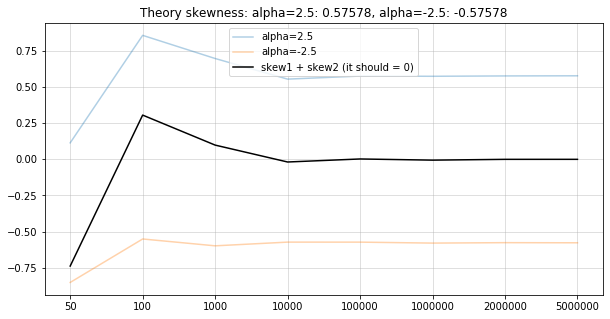

In [9]:
### alpha = 2.5 or -2.5

alpha = 2.5
sk1 = []
sk2 = []
test_size = [50, 100, 1000, 10000, 100000, 1000000, 2000000, 5000000]
for size in test_size:
    x1 = skewnorm.rvs(alpha, loc=0, scale=1, size=size)
    sk1.append(skew(x1))
    x2 = skewnorm.rvs(-alpha, loc=0, scale=1, size=size)
    sk2.append(skew(x2))
    print(f'size = {size}')
    print(f'alpha = {alpha}:   skew={skew(x1)}')
    print(f'alpha = {-alpha}:  skew={skew(x2)}')

# 計算skewnorm的樣本偏度
plt.figure(figsize=(10, 5))
plt.plot(sk1, alpha=0.35, label=f'alpha={alpha}')
plt.plot(sk2, alpha=0.35, label=f'alpha={-alpha}')

sk12 = [i+j for i, j in zip(sk1, sk2)]  # it should be zero, if no sampling error
plt.plot(sk12, color='k', label='skew1 + skew2 (it should = 0)')
plt.grid(True, alpha=0.5)
plt.xticks(ticks=range(len(test_size)), labels=test_size)
plt.legend()
plt.title(f'Theory skewness: alpha={alpha}: {tskew(alpha):.5f}, alpha={-alpha}: {tskew(-alpha):.5f}');

# 似乎alpha大時，算出來的樣本偏度比alpha小時還要更快收斂

#### 接下來的工作：負alpha的情況就不用管了，一律用正值去計算。找要做實驗的偏度時，因為前面顯示若alpha才0.4，且樣本只有千等級的話，算出來的樣本偏度可能誤差有點大，但是如果把樣本放大到更多，就沒辦法用shaoiro檢定了。使用 gen_skewnormal 時，樣本的平均和變異都和給定的差不多沒問題，不過樣本的偏度可能會有稍大的誤差，所以要順便計算理論的偏度值，多試幾次random_state，以樣本偏度與理論值最接近的那次為準